In [20]:
import os
import pandas as pd
print(os.chdir("G:/UTS/2024/Spring_2024/Advance Data Algorithm and Machine Learning/DataGeneration-VAE/Instrument Sound Generation"))
print(os.listdir("."))

def rename_audio_files(csv_file, audio_folder):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Create a dictionary to keep track of the count for each class
    class_count = {}
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        file_name = row['FileName']
        class_name = row['Class']
        
        # Update the count for the class
        if class_name not in class_count:
            class_count[class_name] = 0
        class_count[class_name] += 1
        
        # Construct the new file name
        new_file_name = f"{class_name}_{class_count[class_name]}.wav"
        
        # Get the full path for the old and new file names
        old_file_path = os.path.join(audio_folder, file_name)
        # old_file_path = old_file_path[-len(file_name):]
        new_file_path = os.path.join(audio_folder, new_file_name)
        try: 
            # Rename the file
            os.rename(old_file_path, new_file_path)
        except Exception as e:
            print(e)
            print(old_file_path, new_file_path)
        print(f"Renamed {old_file_path} to {new_file_path}")

# Example usage
rename_audio_files('dataset/Metadata_Train.csv', 'dataset/Train_submission')


None
['archive.zip', 'code', 'dataset', 'model']
[WinError 2] The system cannot find the file specified: 'dataset/Train_submission\\1-E1-Major 00.wav' -> 'dataset/Train_submission\\Guitar_1.wav'
dataset/Train_submission\1-E1-Major 00.wav dataset/Train_submission\Guitar_1.wav
Renamed dataset/Train_submission\1-E1-Major 00.wav to dataset/Train_submission\Guitar_1.wav
[WinError 2] The system cannot find the file specified: 'dataset/Train_submission\\1-E1-Major 01.wav' -> 'dataset/Train_submission\\Guitar_2.wav'
dataset/Train_submission\1-E1-Major 01.wav dataset/Train_submission\Guitar_2.wav
Renamed dataset/Train_submission\1-E1-Major 01.wav to dataset/Train_submission\Guitar_2.wav
[WinError 2] The system cannot find the file specified: 'dataset/Train_submission\\1-E1-Major 02.wav' -> 'dataset/Train_submission\\Guitar_3.wav'
dataset/Train_submission\1-E1-Major 02.wav dataset/Train_submission\Guitar_3.wav
Renamed dataset/Train_submission\1-E1-Major 02.wav to dataset/Train_submission\Guitar_

In [21]:
import librosa 
class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, duration, mono):    
        self.sample_rate = sample_rate
        self.duration = duration 
        self.mono = mono
    
    def load(self, file_path):
        signal = librosa.load(file_path, sr =self.sample_rate,
                              duration= self.duration, mono= self.mono)[0]
        return signal
    

In [22]:
import numpy as np 
class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        # pass # [1, 2, 3] - > 2 -> [0,0, 1,2,3]
        padded_array = np.pad(array, 
                              (num_missing_items, 0),
                              mode = self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        # pass# [1, 2, 3] - > 2 -> [ 1,2,3, 0,0]
        padded_array = np.pad(array, 
                              (0, num_missing_items),
                              mode = self.mode)
        return padded_array



In [23]:
class LogSpectogramExtractor:
    """LgSpectopgramExtractor extracts log spectogtram (in db) from a time-series signal"""

    def __init__(self,  framee_size, hop_length):
        self.frame_size = framee_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft= self.frame_size,
                            hop_length= self.hop_length) [:-1] # -1 to get even number of bins
        print("SHAPE: ", stft.shape)
        # (1 + frame_size /2,  num_frames) 1024 -> 513 -> 512
        spectogram = np.abs(stft)
        log_spectogram = librosa.amplitude_to_db(spectogram)
        return log_spectogram

In [24]:
class MinMaxNormaliser:
    """MinMaxNormalizer applies min max normalization to an array"""
    
    def __init__(self, min_val, max_val): 
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array- array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max -self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array =  (norm_array - self.min) /(self.max - self.min) 
        array = array *  (original_max - original_min) + original_min
        return array

In [25]:
import os 
import pickle 
class Saver:
    """ Saver is responsible to save featurs, and the min max values. """
    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.min_max_values_save_dir = min_max_values_save_dir
    
    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)


    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name+ ".npy")
        return save_path

In [26]:


class PreprocessingPipeline:
    """ Preprocessing Pipeline processes an audio files in a directory , by applying the foillowing steps to each file:
        1. load a file
        2. pad the signal ( if necessary) 
        3. extracting  log spectogram from signal 
        4. normalize the sprctogram
        5. save the normalized spectogram
    """
    
    def __init__(self):
        self.loader = None
        self.padder = None 
        self.extractor = None 
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader
    
    @loader.setter
    def loader(self, loader):
        self._loader =loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)
    


        
    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in file:
                file_path = os.path.join( root, file)
                self._process_file(file_path)
                print(f"Processeed file {file_path}")
            self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_path):
        signal =  self.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        norm_feature =self.normaliser.normalise(feature)
        save_path = self.saver.save_featture(norm_feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.mac())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True

    def _apply_padding(self, signal):
        num_missing_sampels = self._num_expected_samples - len(signal)
        padded_signal =self.padder.right_pad(signal, num_missing_sampels)
        return padded_signal
    
    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }


In [27]:
class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                file_path = os.path.join(root, file)
                self._process_file(file_path)
                print(f"Processed file {file_path}")
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        norm_feature = self.normaliser.normalise(feature)
        save_path = self.saver.save_feature(norm_feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.max())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }

In [43]:
FRAME_SIZE =  512
HOP_LENGTH = 256
DURATION = 1.48 # in seconds
# DURATION = 0.74 # in seconds
SAMPLE_RATE = 22050 
MONO = True

SPECTROGRAMS_SAVE_DIR = "dataset/spectrograms/"
# SPECTROGRAMS_SAVE_DIR = "dataset/spectograms/"
MIN_MAX_VALUES_SAVE_DIR = "dataset/"
FILES_DIR = "dataset/Train_submission/"

# instantiate all objects
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_spectogram_extractor = LogSpectogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = MinMaxNormaliser(0,1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

Preprocessing_pipeline = PreprocessingPipeline()
Preprocessing_pipeline.loader = loader
Preprocessing_pipeline.padder = padder
Preprocessing_pipeline.extractor = log_spectogram_extractor
Preprocessing_pipeline.normaliser = min_max_normaliser
Preprocessing_pipeline.saver = saver

Preprocessing_pipeline.process(FILES_DIR)

SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_1.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_10.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_100.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_101.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_102.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_103.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_104.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_105.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_106.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_107.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_108.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_109.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_11.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_110.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_2684\1319178688.py:9: RuntimeWarning: invalid value encountered in divide
  norm_array = (array- array.min()) / (array.max() - array.min())


SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_81.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_82.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_83.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_84.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_85.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_86.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_87.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_88.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_89.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_9.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_90.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_91.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_92.wav
SHAPE:  (256, 128)
Processed file dataset/Train_submission/Drum_93.wav
SHAPE: 

# Load the spectograms

In [29]:
def load_fsdd(spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames, 1)
            x_train.append(spectrogram)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis] # -> (3000, 256, 64, 1)
    return x_train

In [31]:
spectograms = load_fsdd(SPECTROGRAMS_SAVE_DIR) 

In [38]:
spectograms.shape,spectograms[0].shape

((2452, 256, 130, 1), (256, 130, 1))

ValueError: For X (131) and Y (257) with flat shading, A should have shape (256, 130, 3) or (256, 130, 4) or (256, 130) or (33280,), not (256, 130, 1)

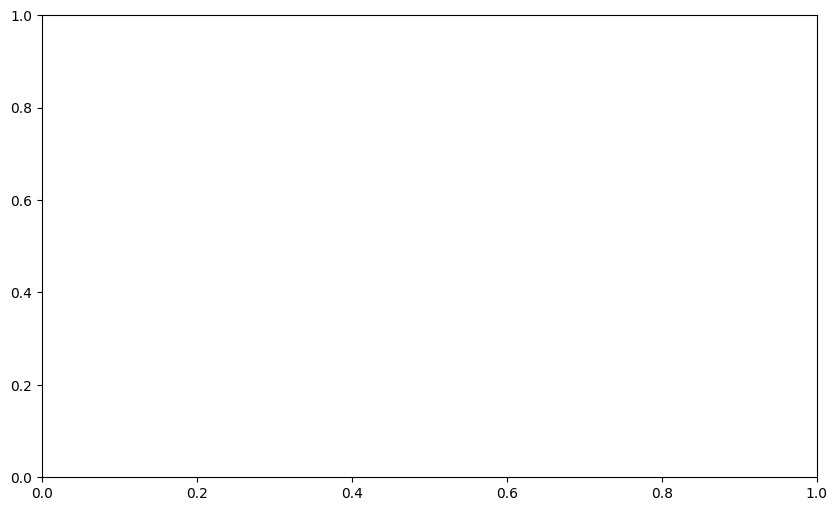

In [35]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

def spectrogram_to_audio(spectrogram, sr=22050, hop_length=256, n_iter=32):
    # Convert the spectrogram to a complex-valued STFT
    stft = librosa.griffinlim(spectrogram, hop_length=hop_length, n_iter=n_iter)
    return stft

# Plot the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(spectograms[0], sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

# Convert the spectrogram back to audio
reconstructed_audio = spectrogram_to_audio(spectograms[0], sr=SAMPLE_RATE, hop_length=HOP_LENGTH)

# Play the reconstructed audio
display(Audio(reconstructed_audio, rate=SAMPLE_RATE))

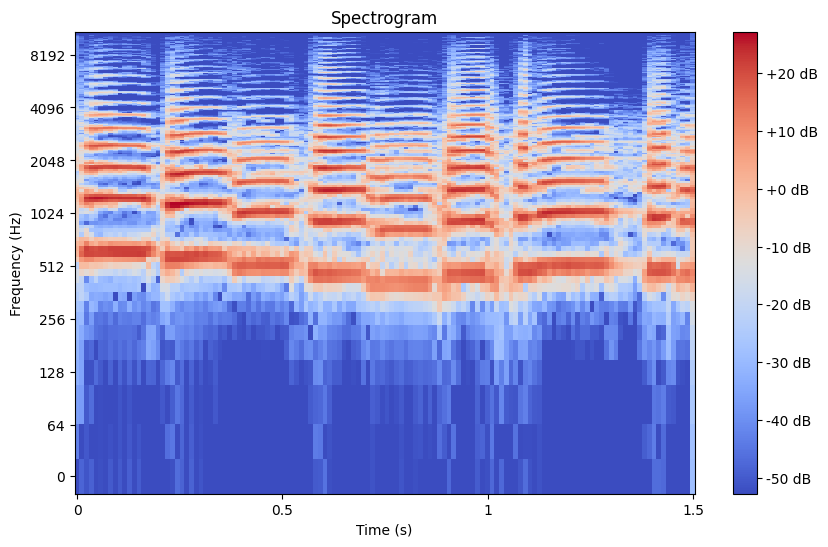

In [34]:


# Parameters
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 1.5  # in seconds
SAMPLE_RATE = 22050

# Load an example audio file
y, sr = librosa.load(librosa.ex('trumpet'), sr=SAMPLE_RATE, duration=DURATION)

# Compute the Short-Time Fourier Transform (STFT)
stft = librosa.stft(y, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
spectrogram = np.abs(stft)

# Convert to decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)




In [39]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import numpy as np

class VAE:
    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        self.input_shape = input_shape 
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim 
        self.encoder = None
        self.decoder = None
        self.model = None
        self._build()

    def _build_encoder(self):
        encoder_input = Input(shape=self.input_shape, name='encoder_input')
        x = encoder_input
        for i in range(len(self.conv_filters)):
            x = Conv2D(filters=self.conv_filters[i],
                       kernel_size=self.conv_kernels[i],
                       strides=self.conv_strides[i],
                       padding='same',
                       name=f'encoder_conv_{i}')(x)
            x = ReLU()(x)
            x = BatchNormalization()(x)
        self._shape_before_bottleneck = K.int_shape(x)[1:]  # Capture the shape before flattening for use in decoder
        x = Flatten()(x)
        mu = Dense(self.latent_space_dim, name='mu')(x)
        log_var = Dense(self.latent_space_dim, name='log_var')(x)
        encoder_output = Lambda(self.sample_point_from_normal_distribution, name='encoder_output')([mu, log_var])
        self.encoder = Model(encoder_input, encoder_output, name='encoder')

    def _build_decoder(self):
        decoder_input = Input(shape=(self.latent_space_dim,), name='decoder_input')
        x = Dense(np.prod(self._shape_before_bottleneck))(decoder_input)
        x = Reshape(self._shape_before_bottleneck)(x)
        for i in reversed(range(len(self.conv_filters))):
            x = Conv2DTranspose(filters=self.conv_filters[i],
                                kernel_size=self.conv_kernels[i],
                                strides=self.conv_strides[i],
                                padding='same',
                                name=f'decoder_conv_{i}')(x)
            x = ReLU()(x)
            x = BatchNormalization()(x)
        decoder_output = Conv2DTranspose(filters=1, kernel_size=self.conv_kernels[0], activation='sigmoid', padding='same', name='decoder_output')(x)
        self.decoder = Model(decoder_input, decoder_output, name='decoder')

    def _build_autoencoder(self):
        model_input = Input(shape=self.input_shape, name='autoencoder_input')
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name='autoencoder')

    def sample_point_from_normal_distribution(self, args):
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

    def summary(self):
        print("\nEncoder Summary")
        self.encoder.summary()
        print("\nDecoder Summary")
        self.decoder.summary()
        print("\nAutoencoder Summary")
        self.model.summary()

# Example usage
# vae = VAE(
#     input_shape=(28, 28, 1),
#     conv_filters=(32, 64, 64, 64),
#     conv_kernels=(3, 3, 3, 3),
#     conv_strides=(1, 2, 2, 1),
#     latent_space_dim=2
# )
vae = VAE(
        input_shape=(256, 130, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=(3, 3, 3, 3, 3),
        conv_strides=(2, 2, 2, 2, (2, 1)),
        # conv_strides = ((2, 1), (2, 2), (2, 2), (2, 2), (2, 2)),
        latent_space_dim=128
    )
vae.summary()


AttributeError: 'VAE' object has no attribute '_build'

In [6]:
import pickle 
import os
os.chdir("G:/UTS/2024/Spring_2024/Advance Data Algorithm and Machine Learning/DataGeneration-VAE/Instrument Sound Generation")

with open("dataset/min_max_values.pkl", "rb") as f:
    min_max_values = pickle.load(f)

In [7]:
min_max_values

{'dataset/spectrograms/Drum_1.npy': {'min': -39.227486, 'max': 40.772514},
 'dataset/spectrograms/Drum_10.npy': {'min': -41.982315, 'max': 38.017685},
 'dataset/spectrograms/Drum_100.npy': {'min': -50.103878, 'max': 29.896122},
 'dataset/spectrograms/Drum_101.npy': {'min': -39.938713, 'max': 40.061287},
 'dataset/spectrograms/Drum_102.npy': {'min': -50.89276, 'max': 29.107239},
 'dataset/spectrograms/Drum_103.npy': {'min': -45.69594, 'max': 34.30406},
 'dataset/spectrograms/Drum_104.npy': {'min': -50.82833, 'max': 29.171667},
 'dataset/spectrograms/Drum_105.npy': {'min': -44.51944, 'max': 35.48056},
 'dataset/spectrograms/Drum_106.npy': {'min': -41.567062, 'max': 38.432938},
 'dataset/spectrograms/Drum_107.npy': {'min': -50.948246, 'max': 29.051754},
 'dataset/spectrograms/Drum_108.npy': {'min': -51.496628, 'max': 28.50337},
 'dataset/spectrograms/Drum_109.npy': {'min': -48.828983, 'max': 31.171017},
 'dataset/spectrograms/Drum_11.npy': {'min': -40.818714, 'max': 39.181286},
 'dataset/

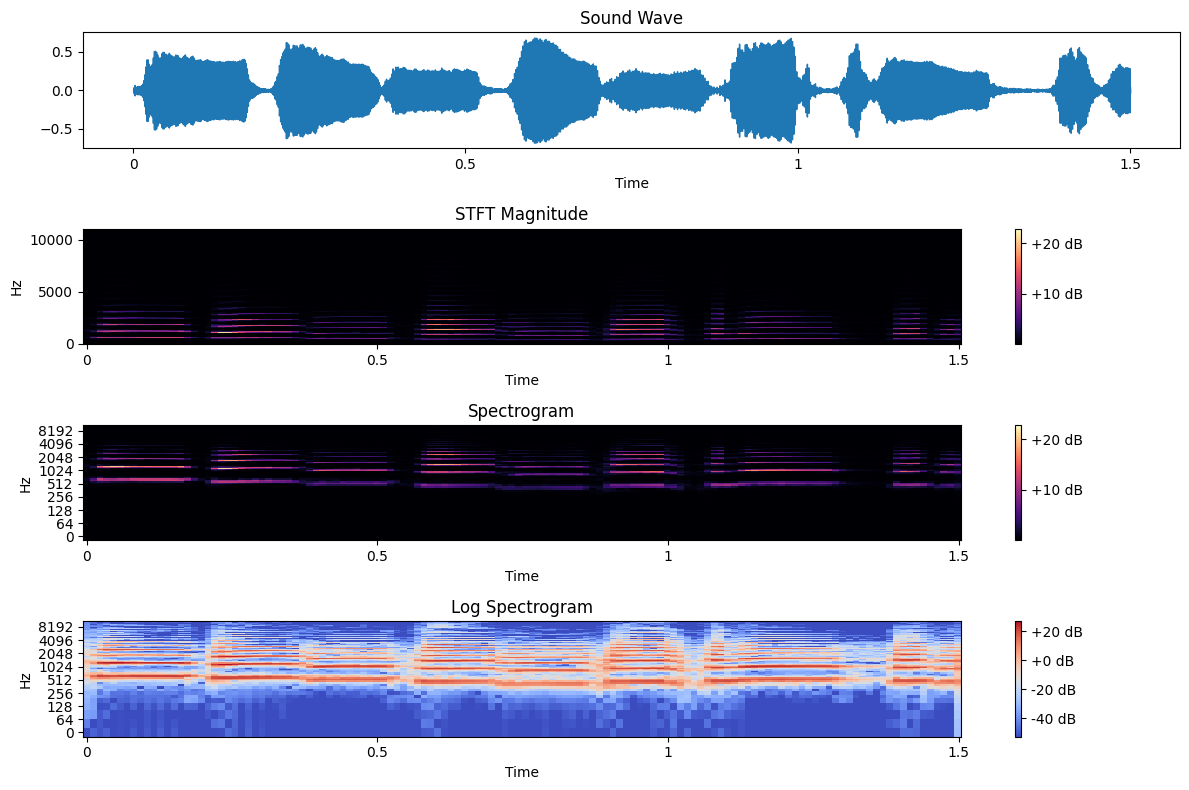

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Parameters
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 1.5  # in seconds
SAMPLE_RATE = 22050

# Load an example audio file
y, sr = librosa.load(librosa.ex('trumpet'), sr=SAMPLE_RATE, duration=DURATION)

# Compute the Short-Time Fourier Transform (STFT)
stft = librosa.stft(y, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
spectrogram = np.abs(stft)

# Convert to decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# Plot the sound wave
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Sound Wave')

# Plot the STFT
plt.subplot(4, 1, 2)
librosa.display.specshow(np.abs(stft), sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Magnitude')

# Plot the spectrogram
plt.subplot(4, 1, 3)
librosa.display.specshow(spectrogram, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Plot the log spectrogram
plt.subplot(4, 1, 4)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Spectrogram')

plt.tight_layout()
plt.show()


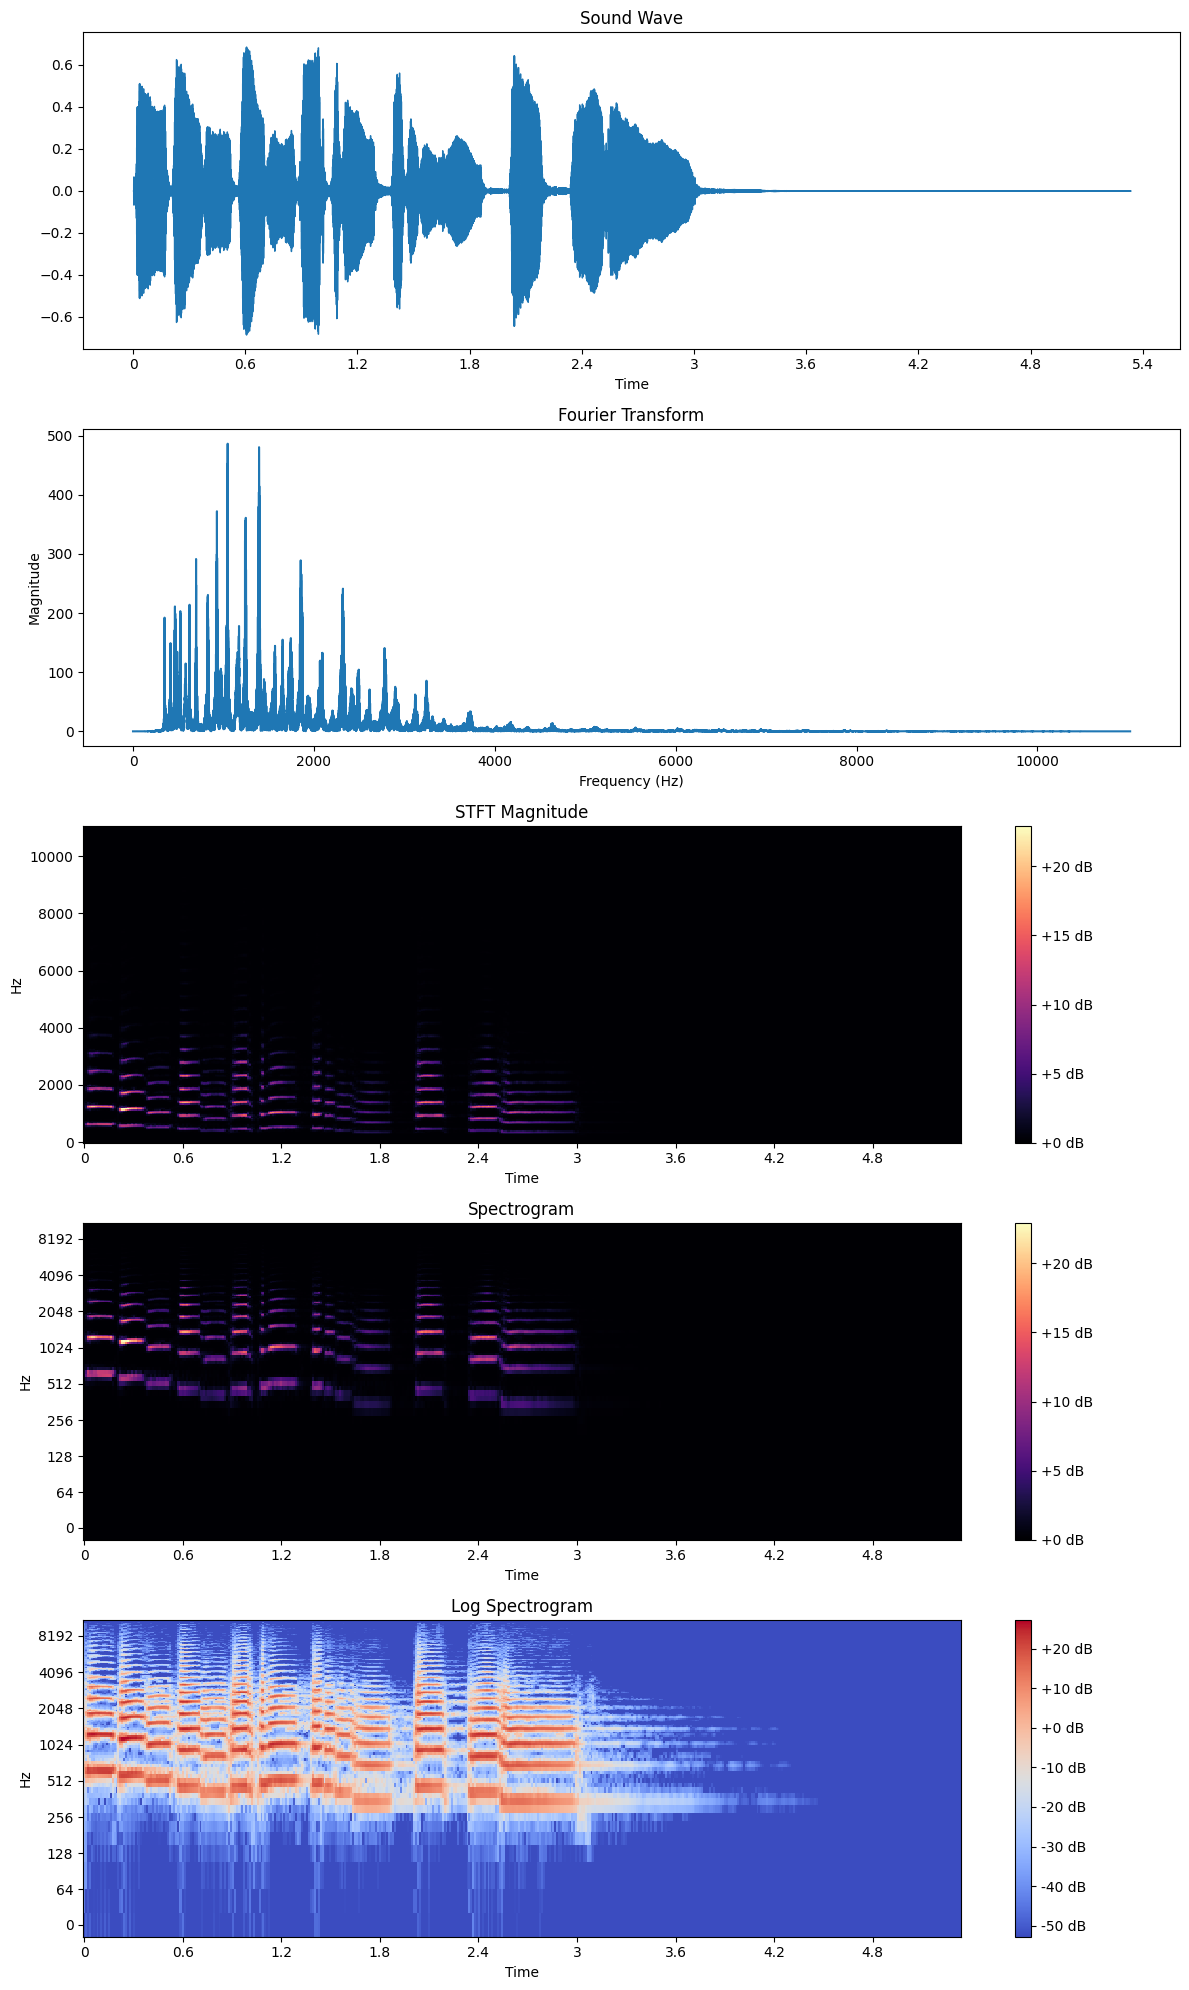

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Parameters
FRAME_SIZE = 512
HOP_LENGTH = 256
# DURATION = 1.5  # in seconds
DURATION = 5.936  # in seconds
SAMPLE_RATE = 22050

# Load an example audio file
y, sr = librosa.load(librosa.ex('trumpet'), sr=SAMPLE_RATE, duration=DURATION)

# Compute the Fourier Transform
fourier_transform = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(fourier_transform), 1 / SAMPLE_RATE)

# Compute the Short-Time Fourier Transform (STFT)
stft = librosa.stft(y, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
spectrogram = np.abs(stft)

# Convert to decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# Plot the sound wave
plt.figure(figsize=(12, 20))

plt.subplot(5, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Sound Wave')

# Plot the Fourier Transform
plt.subplot(5, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fourier_transform)[:len(fourier_transform)//2])
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

# Plot the STFT
plt.subplot(5, 1, 3)
librosa.display.specshow(np.abs(stft), sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Magnitude')

# Plot the spectrogram
plt.subplot(5, 1, 4)
librosa.display.specshow(spectrogram, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Plot the log spectrogram
plt.subplot(5, 1, 5)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Spectrogram')

plt.tight_layout()
plt.show()
